In [1]:
import cv2 
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import numpy as np
from tqdm import tqdm
import os

In [2]:
sea_images = []
other_images = []
    
for file in tqdm(os.listdir("./Data/Mer")):
    sea_images.append('./Data/Mer/' + file)
    
for file in tqdm(os.listdir("./Data/Ailleurs")):
    other_images.append("./Data/Ailleurs/" + file)

100%|██████████| 249/249 [00:00<00:00, 1366991.75it/s]


In [20]:
contrasts_other = []
contrasts_sea = []
dissimilarities_other = []
dissimilarities_sea = []
homogeneities_other = []
homogeneities_sea = []
asm_other = []
asm_sea = []
energy_other = []
energy_sea = []
correlation_other = []
correlation_sea = []

from PIL import Image

w = 1200

dist = [2]
ang = [0]

for file in tqdm(os.listdir("./Data/Ailleurs")):
#     image = Image.open("./Data/Ailleurs/" + file).convert('L').resize((w, w)).crop((0, w/2, w, w))
    image = cv2.imread ("./Data/Ailleurs/" + file ,0)
    cv2.resize(image, (w,w))
    glcm = graycomatrix(image, distances=dist, angles=ang, levels=256,
                        symmetric=True, normed=True)
    
    contrasts_other.append(graycoprops(glcm, 'contrast')[0, 0])
    dissimilarities_other.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    homogeneities_other.append(graycoprops(glcm, 'homogeneity')[0, 0])
    asm_other.append(graycoprops(glcm, 'ASM')[0, 0])
    energy_other.append(graycoprops(glcm, 'energy')[0, 0])
    correlation_other.append(graycoprops(glcm, 'correlation')[0, 0])
    
    
for file in tqdm(os.listdir("./Data/Mer")):
#     image = Image.open("./Data/Mer/" + file).convert('L').resize((w, w)).crop((0, w/2, w, w))

    image = cv2.imread ("./Data/Mer/" + file ,0)
#     cv2.resize(image, (w,w))
#     image = image[600:, 0:]
    glcm = graycomatrix(image, distances=dist, angles=ang, levels=256,
                        symmetric=True, normed=True)
    
    contrasts_sea.append(graycoprops(glcm, 'contrast')[0, 0])
    dissimilarities_sea.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    homogeneities_sea.append(graycoprops(glcm, 'homogeneity')[0, 0])
    asm_sea.append(graycoprops(glcm, 'ASM')[0, 0])
    energy_sea.append(graycoprops(glcm, 'energy')[0, 0])
    correlation_sea.append(graycoprops(glcm, 'correlation')[0, 0])

100%|████████████████████████████████████████| 201/201 [00:00<00:00, 240.06it/s]


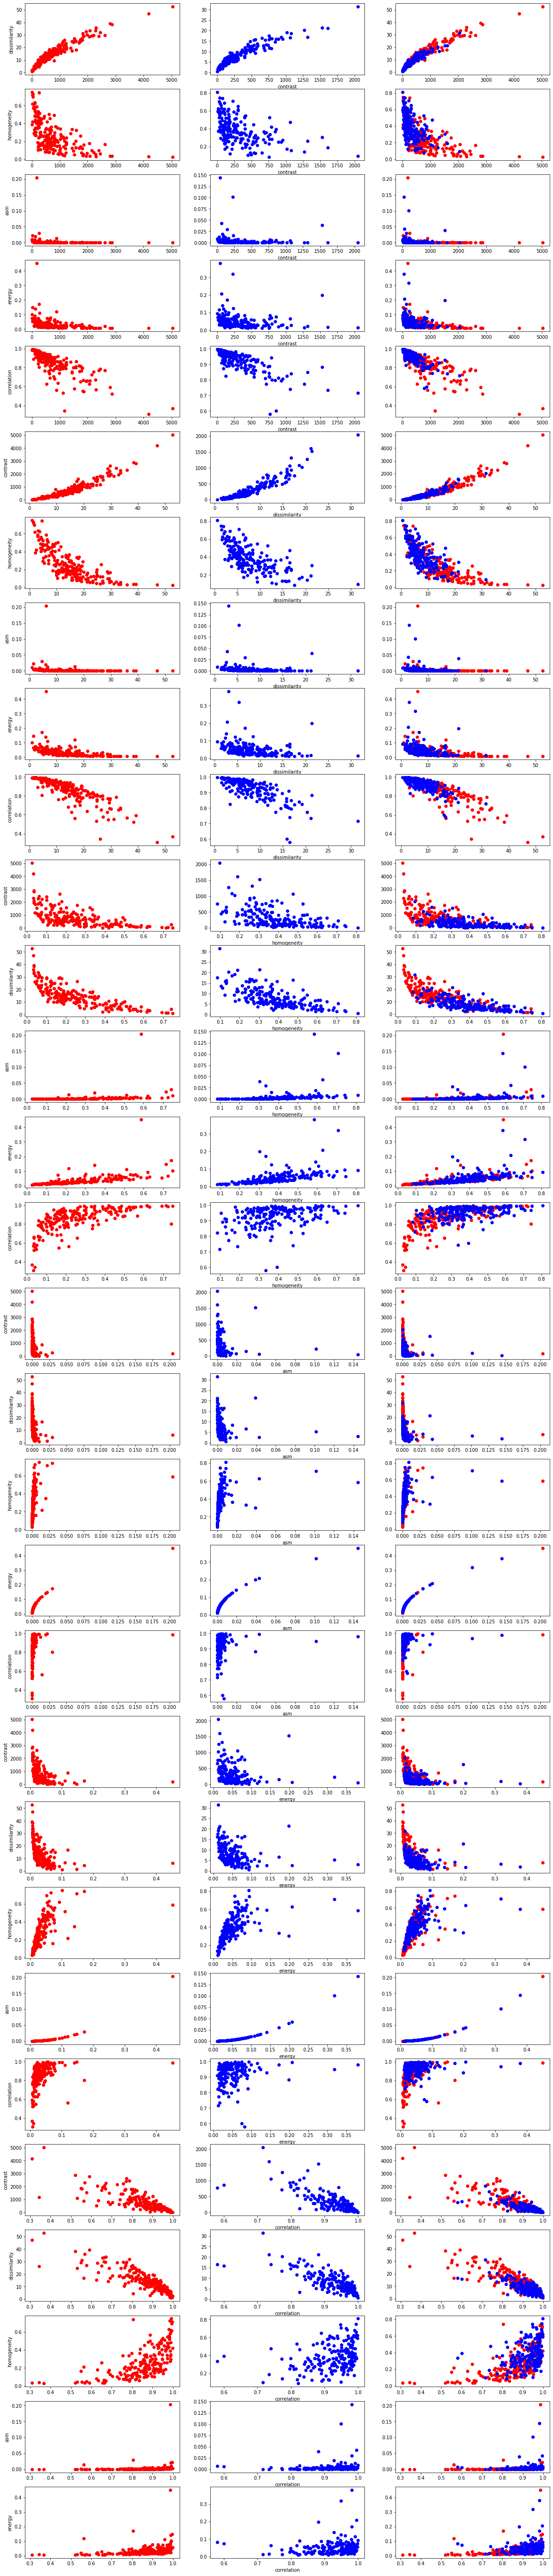

In [21]:
fig, axis = plt.subplots(30, 3, figsize=(20,100))
coprops = []
coprops.append(('contrast', contrasts_other, contrasts_sea))
coprops.append(('dissimilarity', dissimilarities_other, dissimilarities_sea))
coprops.append(('homogeneity', homogeneities_other, homogeneities_sea))
coprops.append(('asm', asm_other, asm_sea))
coprops.append(('energy', energy_other, energy_sea))
coprops.append(('correlation', correlation_other, correlation_sea))

row_index = 0
for coprop in coprops :
    for other_coprop in coprops:
        if coprop == other_coprop: continue
        axis[row_index][0].scatter(coprop[1], other_coprop[1], label="Other", color="r")
        axis[row_index][1].scatter(coprop[2], other_coprop[2], label="Sea", color="b")
        axis[row_index][2].scatter(coprop[1], other_coprop[1], label="Other", color="r")
        axis[row_index][2].scatter(coprop[2], other_coprop[2], label="Sea", color="b")
        
        axis[row_index][1].set(xlabel=coprop[0])
        axis[row_index][0].set(ylabel=other_coprop[0])
        row_index+= 1

In [3]:
from skimage import feature, transform
def angle_to_hori(p1, p2):
    # source : https://stackoverflow.com/questions/7586063/how-to-calculate-the-angle-between-a-line-and-the-horizontal-axis
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    theta = np.arctan2(dy, dx)
    return np.degrees(theta)


def compute_hvt_props(imarray):
    """
    Nécessite une image en niveaux gris
    """
    # source : https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html
    canny_imarray = feature.canny(imarray, 5, 1, 19)  # filtre pour retrouver les contours
    lines = transform.probabilistic_hough_line(canny_imarray, threshold=10, line_length=25, line_gap=10)
    h, v, t = 0, 0, 0
    for p0, p1 in lines:
        angle = np.abs(angle_to_hori(p0, p1))
        if 60 <= angle <= 120 or 240 <= angle <= 300:
            v += 1
        elif 0 <= angle <= 20 or 340 <= angle <= 360 or 160 <= angle <= 200:
            h += 1
        else:
            t += 1
    tot = len(lines) + 1
    return h / tot, v / tot, t / tot, canny_imarray

In [7]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, rgb2gray
X = []
y = []

w = 1200

dist = [2]
ang = [0]

for file in tqdm(os.listdir("./Data/Ailleurs")):
    img = imread("./Data/Ailleurs/" + file)[:,:,:3]
    img = resize(img, (w,w))
    sum = 0
    for i in range(w):
        for j in range(w):
            sum += img[i,j,2]

    image = cv2.imread ("./Data/Ailleurs/" + file ,0)
    cv2.resize(image, (w,w))
    glcm = graycomatrix(image, distances=[3], angles=[0], levels=256,
                        symmetric=True, normed=True)

    imarray = resize(imread("./Data/Ailleurs/" + file), (800, 800), anti_aliasing=True)
    imarray_l = rgb2gray(imarray[:, :, :3]) * 255
    # im_blurred = nd.median_filter(imarray_l, size=13)
    h, v, t, _ = compute_hvt_props(imarray_l[150:,:])
    
    img_data = []
    # img_data.append(graycoprops(glcm, 'contrast')[0, 0])
    img_data.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    img_data.append(graycoprops(glcm, 'homogeneity')[0, 0])
#     img_data.append(graycoprops(glcm, 'ASM')[0, 0])
#     img_data.append(graycoprops(glcm, 'energy')[0, 0])
#     img_data.append(graycoprops(glcm, 'correlation')[0, 0])
    img_data.append(sum)
    img_data.append(h)
    img_data.append(v)
    # img_data.append(t)

    X.append(img_data)
    y.append(0)
    
    
for file in tqdm(os.listdir("./Data/Mer")):
    img = imread("./Data/Mer/" + file)[:,:,:3]
    img = resize(img, (w,w))
    sum = 0
    for i in range(w):
        for j in range(w):
            sum += img[i,j,2]

    image = cv2.imread ("./Data/Mer/" + file ,0)
    cv2.resize(image, (w,w))
    glcm = graycomatrix(image, distances=[3], angles=[0], levels=256,
                        symmetric=True, normed=True)

    imarray = resize(imread("./Data/Mer/" + file), (800, 800), anti_aliasing=True)
    imarray_l = rgb2gray(imarray[:, :, :3]) * 255
    # im_blurred = nd.median_filter(imarray_l, size=13)
    h, v, t, _ = compute_hvt_props(imarray_l[150:,:])

    img_data = []
    # img_data.append(graycoprops(glcm, 'contrast')[0, 0])
    img_data.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    img_data.append(graycoprops(glcm, 'homogeneity')[0, 0])
#     img_data.append(graycoprops(glcm, 'ASM')[0, 0])
#     img_data.append(graycoprops(glcm, 'energy')[0, 0])
#     img_data.append(graycoprops(glcm, 'correlation')[0, 0])
    img_data.append(sum)
    img_data.append(h)
    img_data.append(v)
    # img_data.append(t)
    
    X.append(img_data)
    y.append(1)

100%|██████████| 246/246 [02:18<00:00,  1.77it/s]


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Moyenne : 0.7642424242424244, Variance : 0.001255422916028977, Écart-type : 0.035431947674788876


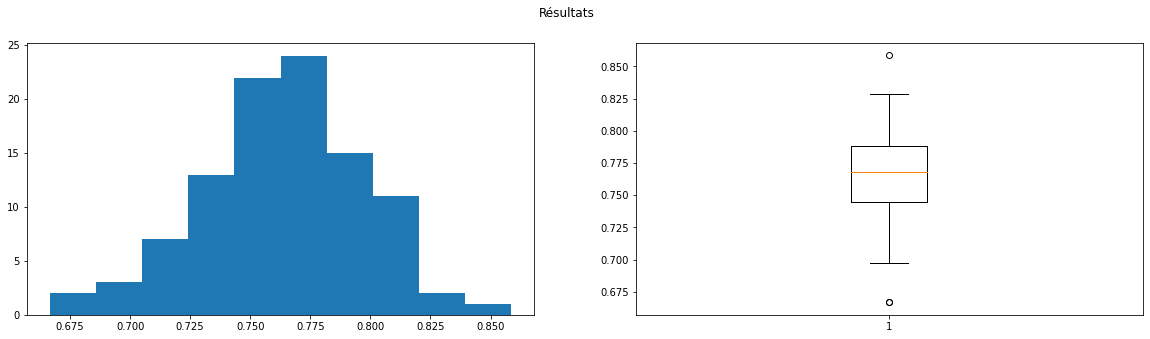

In [8]:
def plot_results(clf_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('Résultats')
    ax1.hist(clf_scores)
    ax2.boxplot(clf_scores)

    print("Moyenne : " + str(np.mean(clf_scores)) + ", Variance : " + str(np.var(clf_scores))
          + ", Écart-type : " + str(np.std(clf_scores)))


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifieur = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=5)

nb_runs = 100
clf_scores = []
for i in tqdm(range(nb_runs)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    classifieur.fit(X_train, y_train)
    y_predits = classifieur.predict(X_test)
    clf_scores.append(accuracy_score(y_test, y_predits))
plot_results(clf_scores)

In [27]:
classifieur.fit(X, y)
from joblib import dump
dump(classifieur, 'comatrix.joblib') 

['comatrix.joblib']